## Import Packages

In [4]:
import cv2
import glob
from ipywidgets import interact
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pickle
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import time

# import additional packages to work with video files
from IPython.display import HTML
from moviepy.editor import VideoFileClip

%matplotlib inline

print('...')

...


## Explore Dataset

_**Note:** Before running the code below, download and unzip Udacity's vehicle.zip and non-vehicles.zip by running_ `./load_dataset.sh` _from command line_


In [5]:
# find and save all vehicle image and non-vehicle image file paths into list objects
vehicle_img_fpaths = glob.glob('dataset/vehicles/**/*.png')
non_vehicle_img_fpaths = glob.glob('dataset/non-vehicles/**/*.png')

print('...')

...


In [6]:
# get number of vehicle images and non-vehicle images
print("Number of vehicle images: {} \nNumber of non-vehicle images: {}".format(len(vehicle_img_fpaths), 
                                                                               len(non_vehicle_img_fpaths)))

Number of vehicle images: 8792 
Number of non-vehicle images: 8968


In [7]:
# get shape of vehicle and non-vehicle iamges
example_vehicle_img = mpimg.imread(vehicle_img_fpaths[0])
example_non_vehicle_img = mpimg.imread(non_vehicle_img_fpaths[0])
print("Shape of example vehicle image: {} \nShape of example non-vehicle images: {}".format(
    example_vehicle_img.shape, example_non_vehicle_img.shape))

Shape of example vehicle image: (64, 64, 3) 
Shape of example non-vehicle images: (64, 64, 3)


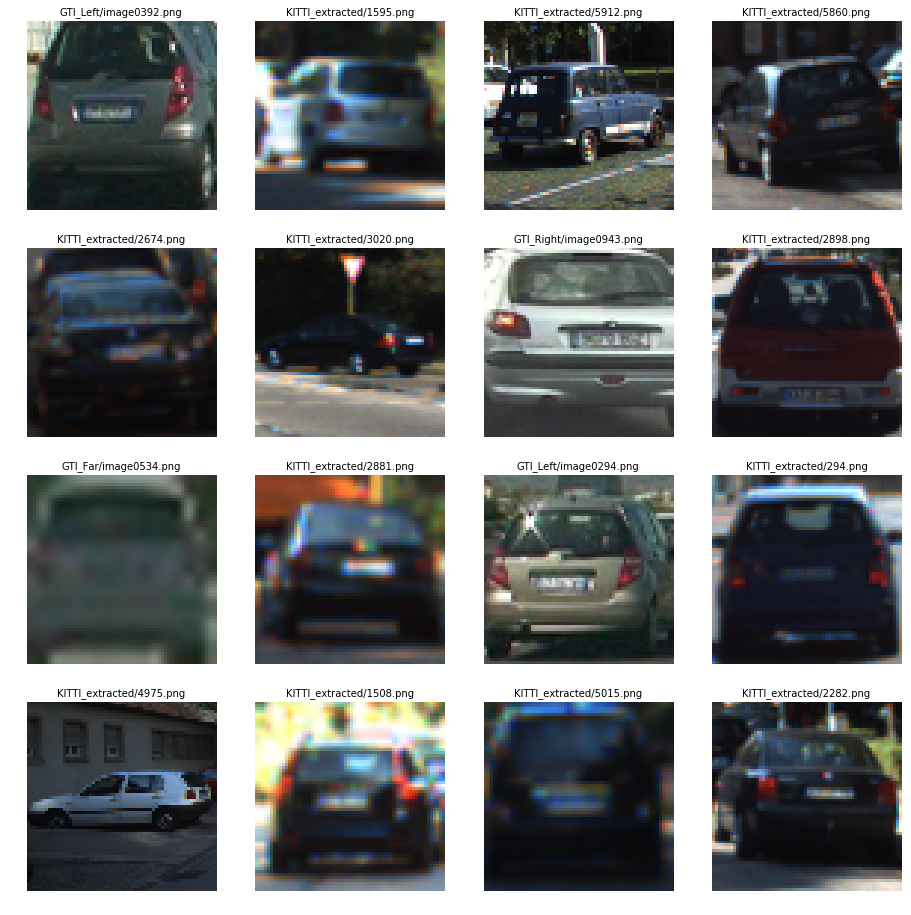

In [8]:
# visualize random selection of 16 vehicle images
fig, axes = plt.subplots(4,4, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.1)
axes = axes.ravel()

for i in np.arange(16):
    vehicle_img_fpath = vehicle_img_fpaths[np.random.randint(0,len(vehicle_img_fpaths))]
    vehicle_img_title = os.path.join(vehicle_img_fpath.split('/')[2], vehicle_img_fpath.split('/')[3])
    img = mpimg.imread(vehicle_img_fpath)
    axes[i].axis('off')
    axes[i].set_title(vehicle_img_title, fontsize=10)
    axes[i].imshow(img)

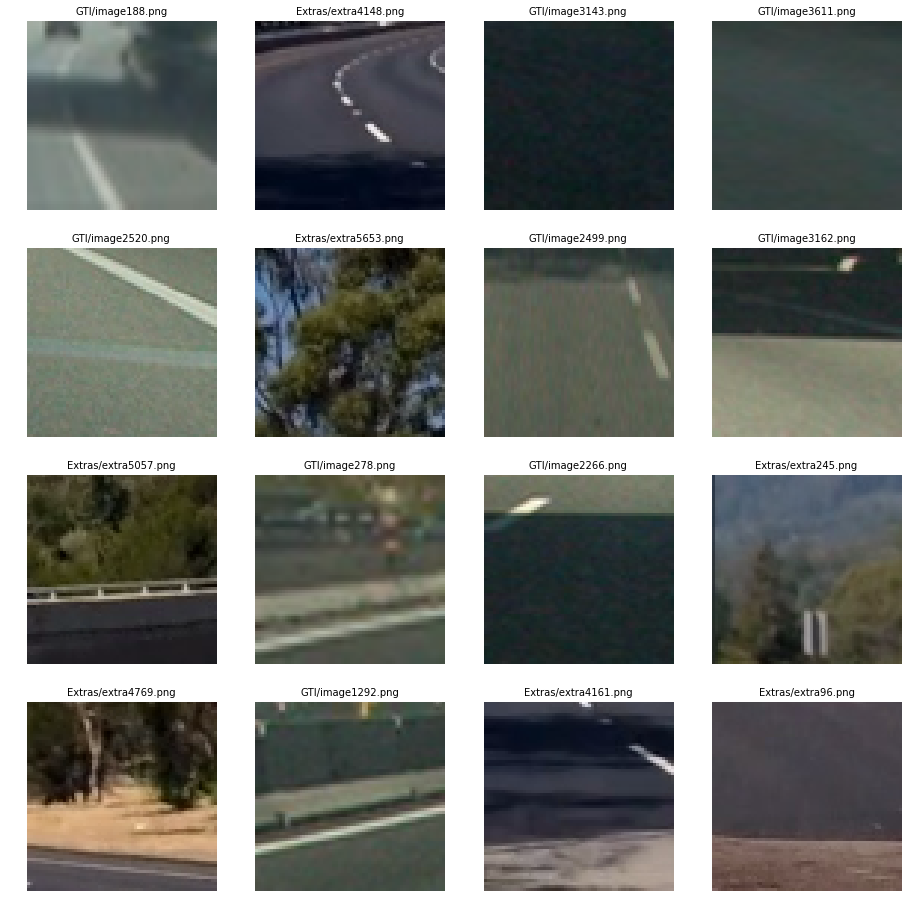

In [9]:
# visualize random selection of 16 non-vehicle images
fig, axes = plt.subplots(4,4, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.1)
axes = axes.ravel()

for i in np.arange(16):
    non_vehicle_img_fpath = non_vehicle_img_fpaths[np.random.randint(0,len(non_vehicle_img_fpaths))]
    non_vehicle_img_title = os.path.join(non_vehicle_img_fpath.split('/')[2], non_vehicle_img_fpath.split('/')[3])
    img = mpimg.imread(non_vehicle_img_fpath)
    axes[i].axis('off')
    axes[i].set_title(non_vehicle_img_title, fontsize=10)
    axes[i].imshow(img)

## Display Histogram of Oriented Gradients (HOG) on Example Images

In [10]:
# function provided on Udacity's course
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

print('...')

...


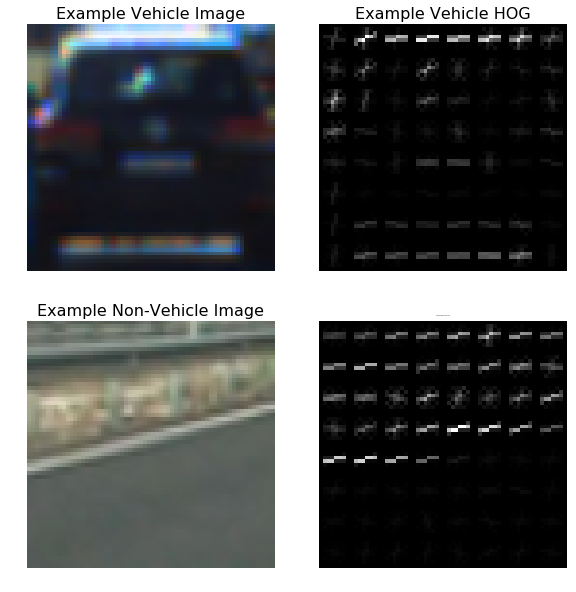

In [27]:
example_vehicle_img = mpimg.imread(vehicle_img_fpaths[np.random.randint(0,len(vehicle_img_fpaths))])
example_non_vehicle_img = mpimg.imread(non_vehicle_img_fpaths[np.random.randint(0,len(non_vehicle_img_fpaths))])

_, example_vehicle_hog = get_hog_features(example_vehicle_img, 
                                          orient = 8, 
                                          pix_per_cell = 8, 
                                          cell_per_block = 2,
                                          vis=True, 
                                          feature_vec=True)

_, example_non_vehicle_hog = get_hog_features(example_non_vehicle_img, 
                                          orient = 8, 
                                          pix_per_cell = 8, 
                                          cell_per_block = 2,
                                          vis=True, 
                                          feature_vec=True)


fig, axes = plt.subplots(2,2, figsize=(10, 10))
fig.subplots_adjust(hspace = .2, wspace=.1)
axes = axes.ravel()

for i in range(4):
    axes[i].axis('off')  
    
axes[0].imshow(example_vehicle_img)
axes[0].set_title('Example Vehicle Image', fontsize = 16)
axes[1].imshow(example_vehicle_hog, cmap = 'gray')
axes[1].set_title('Example Vehicle HOG', fontsize = 16)
axes[2].imshow(example_non_vehicle_img)
axes[2].set_title('Example Non-Vehicle Image', fontsize = 16)
axes[3].imshow(example_non_vehicle_hog, cmap = 'gray')
axes[3].set_title('Example Non-Vehicle HOG', fontsize = 1)

## Explore HOG Parameters

In [24]:
def fiddle_with_hog_params(orients = 8, pxs_per_cell = 8, cells_per_block = 2):
    example_vehicle_img = mpimg.imread(vehicle_img_fpaths[0])
    example_non_vehicle_img = mpimg.imread(non_vehicle_img_fpaths[0])

    _, example_vehicle_hog = get_hog_features(example_vehicle_img, 
                                              orient = orients, 
                                              pix_per_cell = pxs_per_cell, 
                                              cell_per_block = cells_per_block,
                                              vis=True, 
                                              feature_vec=True)

    _, example_non_vehicle_hog = get_hog_features(example_non_vehicle_img, 
                                              orient = orients, 
                                              pix_per_cell = pxs_per_cell, 
                                              cell_per_block = cells_per_block,
                                              vis=True, 
                                              feature_vec=True)


    fig, axes = plt.subplots(2,2, figsize=(10, 10))
    fig.subplots_adjust(hspace = .2, wspace=.1)
    axes = axes.ravel()

    for i in range(4):
        axes[i].axis('off')  

    axes[0].imshow(example_vehicle_img)
    axes[0].set_title('Example Vehicle Image', fontsize = 16)
    axes[1].imshow(example_vehicle_hog, cmap = 'gray')
    axes[1].set_title('Example Vehicle HOG', fontsize = 16)
    axes[2].imshow(example_non_vehicle_img)
    axes[2].set_title('Example Non-Vehicle Image', fontsize = 16)
    axes[3].imshow(example_non_vehicle_hog, cmap = 'gray')
    axes[3].set_title('Example Non-Vehicle HOG', fontsize = 1)

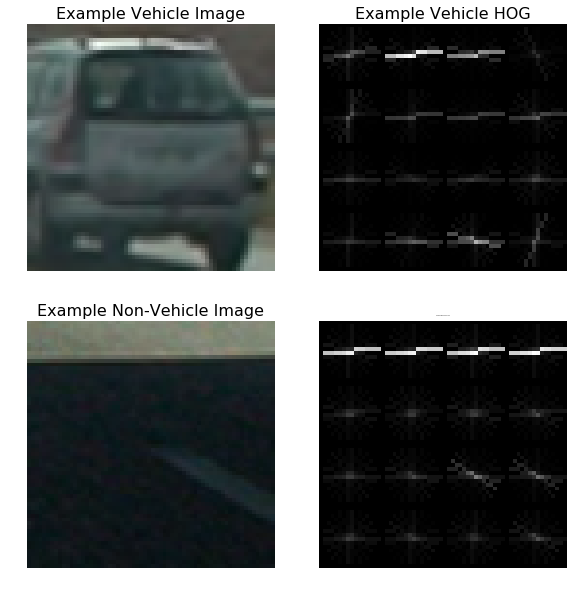

In [29]:
interact(fiddle_with_hog_params,
         orients = (0,16,1),
         pxs_per_cell = (4,16,2),
         cells_per_block = (2,4,1))